Generating spatially shifted data...
Generating varying initial condition data...
Generating clean data...


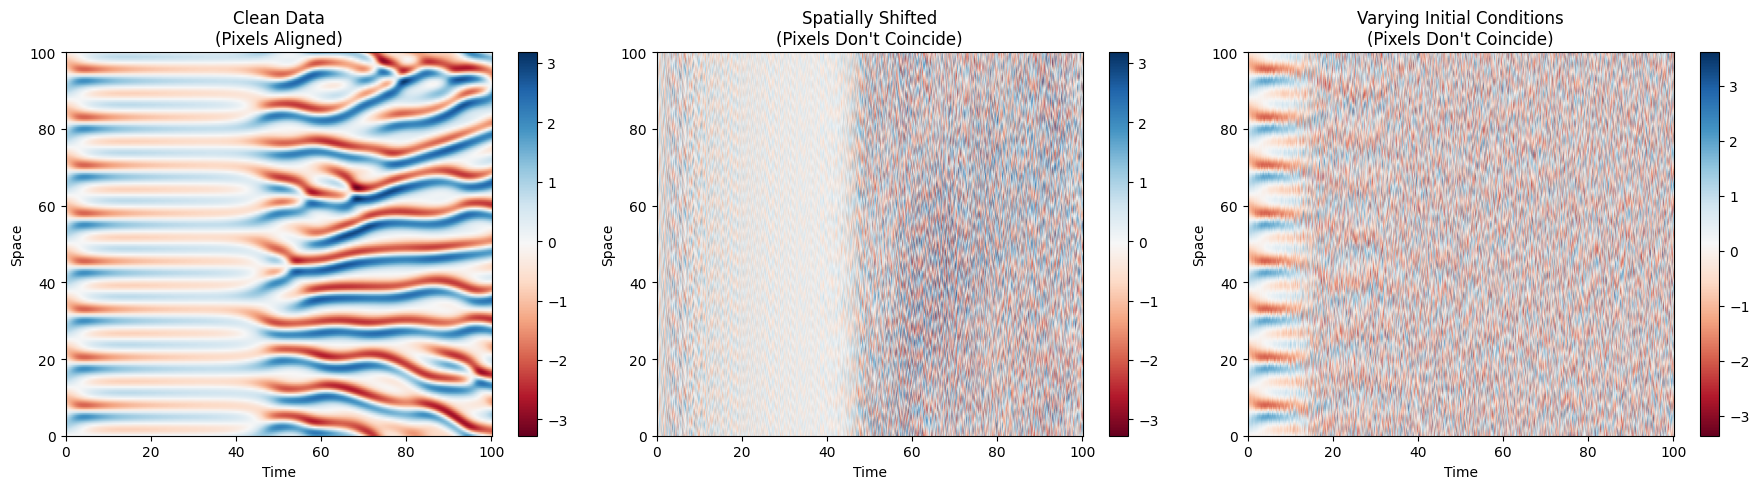

All datasets saved successfully!
Files created:
- test_solving_euler_ks_clean.h5 (aligned pixels)
- test_solving_euler_ks_spatial_shift.h5 (spatial shifts)
- test_solving_euler_ks_varied_ic.h5 (varying initial conditions)


In [11]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import h5py
import numpy as np

DOMAIN_SIZE = 100.0
N_DOF = 200
DT = 0.05 

class KuramotoSivashinsky():
    def __init__(
        self,
        L,
        N,
        dt,
        a=-1.0,
        b=-1.0,
        c=-0.5,
    ):
        self.L = L
        self.N = N
        self.dt = dt
        self.a = a
        self.b = b
        self.c = c

        self.dx = L / N

        # Frequencies (cycles per unit length)
        freqs = jnp.fft.rfftfreq(N, d=self.dx)
        # Convert to angular wavenumbers k = 2pi * freq
        k = 2 * jnp.pi * freqs
        self.derivative_operator = 1j * k

        # Linear operator in Fourier space: a*d^2/dx^2 + b*d^4/dx^4
        linear_operator = self.a * (-k**2) + self.b * (k**4)

        self.exp_term = jnp.exp(dt * linear_operator)
        self.coef = jnp.where(
            linear_operator == 0.0,
            dt,
            (self.exp_term - 1.0) / linear_operator,
        )

        # 2/3 rule dealiasing mask for nonlinear term
        self.alias_mask = (freqs < 2/3 * jnp.max(freqs))

    def __call__(self, u):
        # Nonlinear term c * d/dx (u^2)
        u_nonlin = self.c * u**2
        u_hat = jnp.fft.rfft(u)
        u_nonlin_hat = jnp.fft.rfft(u_nonlin)
        u_nonlin_hat = self.alias_mask * u_nonlin_hat

        u_nonlin_der_hat = self.derivative_operator * u_nonlin_hat

        # Exponential time differencing step
        u_next_hat = self.exp_term * u_hat + self.coef * u_nonlin_der_hat
        u_next = jnp.fft.irfft(u_next_hat, n=self.N)

        return u_next

# Create spatial mesh
mesh = jnp.linspace(0.0, DOMAIN_SIZE, N_DOF, endpoint=False)

# Initial condition
u_0 = jnp.sin(16 * jnp.pi * mesh / DOMAIN_SIZE)

ks_stepper = KuramotoSivashinsky(
    L=DOMAIN_SIZE,
    N=N_DOF,
    dt=DT,
    a=-1.0,
    b=-1.0,
    c=-0.5,
)

ks_stepper = jax.jit(ks_stepper)

# METHOD 1: Spatial Translation (Pixels don't coincide between time steps)
def generate_spatially_shifted_data():
    """Apply slight translations between time steps"""
    u_current = u_0
    trj_shifted = [u_current]
    
    # Generate clean trajectory first
    for i in range(2000):
        u_current = ks_stepper(u_current)
        trj_shifted.append(u_current)
    
    trj_shifted = jnp.stack(trj_shifted)
    
    # Now apply random spatial shifts to break pixel alignment
    rng = np.random.default_rng(42)
    trj_unregistered = []
    
    for i in range(trj_shifted.shape[0]):
        # Random shift between -50 to 50 pixels
        shift = rng.integers(-50, 51)
        shifted_frame = jnp.roll(trj_shifted[i], shift)
        trj_unregistered.append(shifted_frame)
    
    return jnp.stack(trj_unregistered)

# METHOD 2: Varying Initial Conditions (Each time step from different IC)
def generate_varying_ic_data():
    """Each time step comes from slightly different initial conditions"""
    rng = np.random.default_rng(42)
    trj_varied = []
    
    # Base initial condition
    base_u0 = u_0
    
    for i in range(2001):  # Same number of time steps
        # Add small Gaussian noise to initial condition
        noise_level = 0.20  # 20% noise
        perturbed_u0 = base_u0 + noise_level * rng.normal(0, 1, base_u0.shape)
        
        # Simulate forward i steps from perturbed initial condition
        u_current = perturbed_u0
        for step in range(i):  # Simulate exactly i steps
            u_current = ks_stepper(u_current)
        
        trj_varied.append(u_current)
    
    return jnp.stack(trj_varied)

# Generate both types of unregistered data
print("Generating spatially shifted data...")
trj_spatial_shift = generate_spatially_shifted_data()

print("Generating varying initial condition data...")  
trj_varied_ic = generate_varying_ic_data()

# Generate clean data for comparison
print("Generating clean data...")
u_current = u_0
trj_clean = [u_current]
for i in range(2000):
    u_current = ks_stepper(u_current)
    trj_clean.append(u_current)
trj_clean = jnp.stack(trj_clean)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Clean data
im0 = axes[0].imshow(trj_clean.T, cmap="RdBu", aspect="auto", origin="lower",
                    extent=(0, trj_clean.shape[0] * DT, 0, DOMAIN_SIZE))
axes[0].set_title("Clean Data\n(Pixels Aligned)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Space")
plt.colorbar(im0, ax=axes[0])

# Spatially shifted
im1 = axes[1].imshow(trj_spatial_shift.T, cmap="RdBu", aspect="auto", origin="lower",
                    extent=(0, trj_spatial_shift.shape[0] * DT, 0, DOMAIN_SIZE))
axes[1].set_title("Spatially Shifted\n(Pixels Don't Coincide)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Space")
plt.colorbar(im1, ax=axes[1])

# Varying IC
im2 = axes[2].imshow(trj_varied_ic.T, cmap="RdBu", aspect="auto", origin="lower",
                    extent=(0, trj_varied_ic.shape[0] * DT, 0, DOMAIN_SIZE))
axes[2].set_title("Varying Initial Conditions\n(Pixels Don't Coincide)")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Space")
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.savefig("ks_unregistered_data_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Save all datasets
x = jnp.linspace(0.0, DOMAIN_SIZE, N_DOF, endpoint=False)
t = jnp.arange(trj_clean.shape[0]) * DT

# Save clean data
with h5py.File("test_solving_euler_ks_clean.h5", "w") as f:
    f.create_dataset("u", data=trj_clean)
    f.create_dataset("x", data=x)
    f.create_dataset("t", data=t)
    f.attrs["domain_size"] = DOMAIN_SIZE
    f.attrs["n_dof"] = N_DOF
    f.attrs["dt"] = DT
    f.attrs["n_steps"] = trj_clean.shape[0]
    f.attrs["registration"] = "aligned"

# Save spatially shifted data
with h5py.File("test_solving_euler_ks_spatial_shift_50.h5", "w") as f:
    f.create_dataset("u", data=trj_spatial_shift)
    f.create_dataset("x", data=x)
    f.create_dataset("t", data=t)
    f.attrs["domain_size"] = DOMAIN_SIZE
    f.attrs["n_dof"] = N_DOF
    f.attrs["dt"] = DT
    f.attrs["n_steps"] = trj_spatial_shift.shape[0]
    f.attrs["registration"] = "unregistered_spatial_shift"
    f.attrs["perturbation_type"] = "spatial_translation"

# Save varying IC data
with h5py.File("test_solving_euler_ks_varied_ic_20.h5", "w") as f:
    f.create_dataset("u", data=trj_varied_ic)
    f.create_dataset("x", data=x)
    f.create_dataset("t", data=t)
    f.attrs["domain_size"] = DOMAIN_SIZE
    f.attrs["n_dof"] = N_DOF
    f.attrs["dt"] = DT
    f.attrs["n_steps"] = trj_varied_ic.shape[0]
    f.attrs["registration"] = "unregistered_varied_ic"
    f.attrs["perturbation_type"] = "varying_initial_conditions"

print("All datasets saved successfully!")
print("Files created:")
print("- test_solving_euler_ks_clean.h5 (aligned pixels)")
print("- test_solving_euler_ks_spatial_shift.h5 (spatial shifts)")
print("- test_solving_euler_ks_varied_ic.h5 (varying initial conditions)")

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftfreq
from sklearn.linear_model import Lasso



# === Compute spatial derivatives using spectral method ===
def spectral_derivative(u_snapshot, k):
    """Compute first spatial derivative using FFT."""
    u_hat = fft(u_snapshot)
    return np.real(ifft(1j * k * u_hat))

def spectral_second_derivative(u_snapshot, k):
    """Compute second spatial derivative."""
    u_hat = fft(u_snapshot)
    return np.real(ifft(-k**2 * u_hat))

def spectral_fourth_derivative(u_snapshot, k):
    """Compute fourth spatial derivative."""
    u_hat = fft(u_snapshot)
    return np.real(ifft(k**4 * u_hat))

### SINDy on data with spatial shift

In [8]:
with h5py.File("test_solving_euler_ks_spatial_shift.h5", "r") as f:
    u = np.array(f["u"])      # shape (Nt, Nx)
    x = np.array(f["x"])      # spatial grid
    t = np.array(f["t"])      # time grid
    
Nx = len(x)
Nt = len(t)
L = x[-1] - x[0] + (x[1]-x[0])
dx = x[1] - x[0]
dt = t[1] - t[0]
    
print(f"Loaded u(t,x) with shape {u.shape}, dx={dx:.3f}, dt={dt:.3f}")
    
    
# Define wavenumbers
k = 2 * np.pi * fftfreq(Nx, d=dx)
    
# === Compute temporal derivative u_t using finite difference ===
u_t = (u[2:] - u[:-2]) / (2 * dt)          # central difference in time
u_mid = u[1:-1]                            # align time dimension
    
# === Build feature library Θ(u) ===
# For each time snapshot, compute spatial derivatives
Theta = []
ut_flat = []
    
for snapshot, ut_snapshot in zip(u_mid, u_t):
    ux  = spectral_derivative(snapshot, k)
    uxx = spectral_second_derivative(snapshot, k)
    uxxxx = spectral_fourth_derivative(snapshot, k)
    
    # Feature terms
    Theta_snapshot = np.vstack([
            uxx,         # diffusion term
            uxxxx,       # hyperdiffusion
            snapshot * ux, # nonlinear advection term (u * ux)
        ]).T  # shape (Nx, 3)
    
    Theta.append(Theta_snapshot)
    ut_flat.append(ut_snapshot)
    
Theta = np.vstack(Theta)       # shape (Nt*Nx, 3)
ut_flat = np.hstack(ut_flat)   # flatten to 1D (Nt*Nx,)
    
print("Feature matrix Θ shape:", Theta.shape)
print("Target vector u_t shape:", ut_flat.shape)
    
# === Normalize features for numerical stability ===
Theta_mean = Theta.mean(axis=0)
Theta_std = Theta.std(axis=0)
Theta_norm = (Theta - Theta_mean) / Theta_std
    
# === Sparse regression (LASSO) ===
lasso = Lasso(alpha=1e-4, fit_intercept=False)
lasso.fit(Theta_norm, ut_flat)
coeffs = lasso.coef_ / Theta_std  # un-normalize coefficients
    
print("\nRecovered PDE coefficients (Spatial Translation):")
print(f"a (u_xx):     {coeffs[0]:.4f}")
print(f"b (u_xxxx):   {coeffs[1]:.4f}")
print(f"c (u*u_x):    {coeffs[2]:.4f}") # Updated label for the new term
    


Loaded u(t,x) with shape (2001, 200), dx=0.500, dt=0.050
Feature matrix Θ shape: (399800, 3)
Target vector u_t shape: (399800,)

Recovered PDE coefficients (Spatial Translation):
a (u_xx):     -0.2509
b (u_xxxx):   -0.2563
c (u*u_x):    -0.2586


## SINDY on data with different initial conditions

In [9]:
with h5py.File("test_solving_euler_ks_varied_ic.h5", "r") as f:
    u = np.array(f["u"])      # shape (Nt, Nx)
    x = np.array(f["x"])      # spatial grid
    t = np.array(f["t"])      # time grid
    
Nx = len(x)
Nt = len(t)
L = x[-1] - x[0] + (x[1]-x[0])
dx = x[1] - x[0]
dt = t[1] - t[0]
    
print(f"Loaded u(t,x) with shape {u.shape}, dx={dx:.3f}, dt={dt:.3f}")
    
    
# Define wavenumbers
k = 2 * np.pi * fftfreq(Nx, d=dx)
    
# === Compute temporal derivative u_t using finite difference ===
u_t = (u[2:] - u[:-2]) / (2 * dt)          # central difference in time
u_mid = u[1:-1]                            # align time dimension
    
# === Build feature library Θ(u) ===
# For each time snapshot, compute spatial derivatives
Theta = []
ut_flat = []
    
for snapshot, ut_snapshot in zip(u_mid, u_t):
    ux  = spectral_derivative(snapshot, k)
    uxx = spectral_second_derivative(snapshot, k)
    uxxxx = spectral_fourth_derivative(snapshot, k)
    
    # Feature terms
    Theta_snapshot = np.vstack([
            uxx,         # diffusion term
            uxxxx,       # hyperdiffusion
            snapshot * ux, # nonlinear advection term (u * ux)
        ]).T  # shape (Nx, 3)
    
    Theta.append(Theta_snapshot)
    ut_flat.append(ut_snapshot)
    
Theta = np.vstack(Theta)       # shape (Nt*Nx, 3)
ut_flat = np.hstack(ut_flat)   # flatten to 1D (Nt*Nx,)
    
print("Feature matrix Θ shape:", Theta.shape)
print("Target vector u_t shape:", ut_flat.shape)
    
# === Normalize features for numerical stability ===
Theta_mean = Theta.mean(axis=0)
Theta_std = Theta.std(axis=0)
Theta_norm = (Theta - Theta_mean) / Theta_std
    
# === Sparse regression (LASSO) ===
lasso = Lasso(alpha=1e-4, fit_intercept=False)
lasso.fit(Theta_norm, ut_flat)
coeffs = lasso.coef_ / Theta_std  # un-normalize coefficients
    
print("\nRecovered PDE coefficients (Varied Initial Conditions):")
print(f"a (u_xx):     {coeffs[0]:.4f}")
print(f"b (u_xxxx):   {coeffs[1]:.4f}")
print(f"c (u*u_x):    {coeffs[2]:.4f}") # Updated label for the new term
    


Loaded u(t,x) with shape (2001, 200), dx=0.500, dt=0.050
Feature matrix Θ shape: (399800, 3)
Target vector u_t shape: (399800,)

Recovered PDE coefficients (Varied Initial Conditions):
a (u_xx):     0.3510
b (u_xxxx):   0.3509
c (u*u_x):    0.3504
